44100


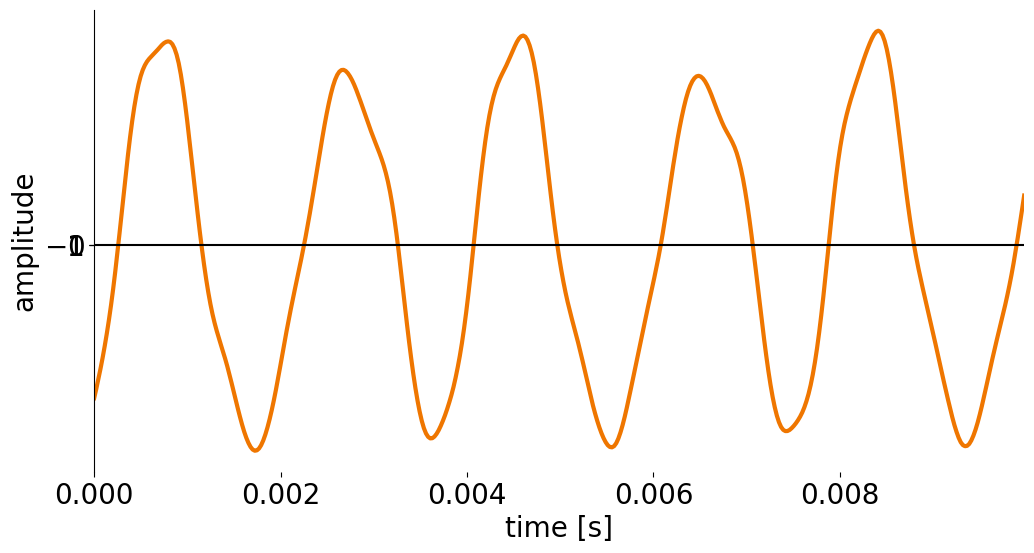

Found peaks (Frequency, Amplitude):
  523.62 Hz, 129721353.70
  785.89 Hz, 22198605.36
  786.16 Hz, 18579882.26
  785.63 Hz, 18168596.88
  260.95 Hz, 18048642.76
  261.35 Hz, 15836682.96
  260.42 Hz, 15054026.42
 1848.36 Hz, 10644648.67
  784.96 Hz, 10031986.34
 1849.02 Hz, 7705133.94


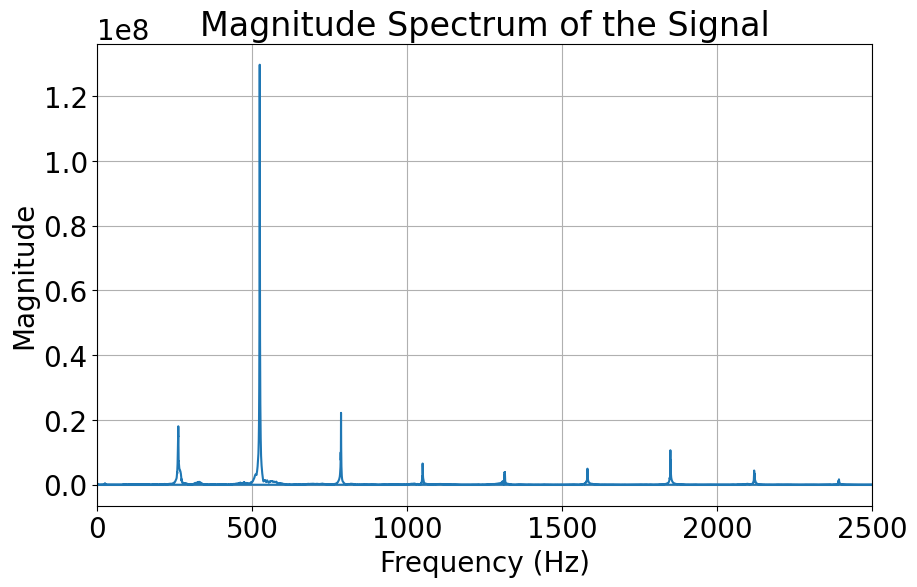

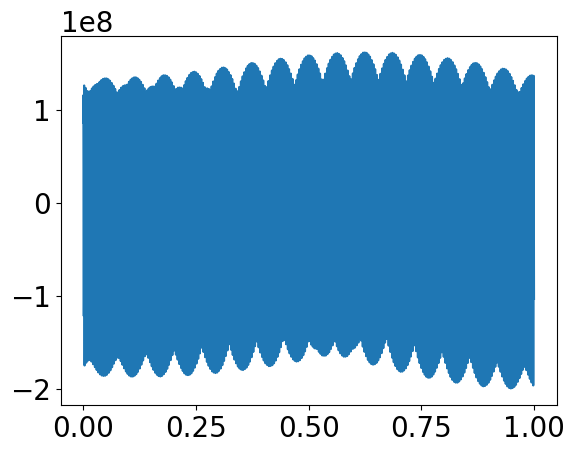

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pydub import AudioSegment
from scipy.signal import find_peaks
import sounddevice as sd

IMG_OUTPUT_PATH = Path('img')
SAVE_PARAMS = {'dpi': 300, 'bbox_inches': 'tight', 'transparent': True}


def plot_signal(signal, time=None):
    plt.rcParams.update({'font.size': 20})
    COLOR = '#ef7600'

    samples_count = signal.shape[0]

    plt.figure(figsize=(12,6))
    if time is None:
        xlim = [0, samples_count]
        plt.plot(signal, COLOR, linewidth=3)
        plt.xlabel('samples')
    else:
        xlim = [time[0], time[-1]]
        plt.plot(time, signal, COLOR, linewidth=3)
        plt.xlabel('time [s]')
    plt.hlines(0, xlim[0], xlim[1], 'k')
    plt.ylabel('amplitude')
    plt.xlim(xlim)
    plt.yticks([-1, 0, 1])

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)


def plot_signal_and_show(signal, time=None):
    plot_signal(signal, time)
    plt.show() # closes the figure


def main():
    audio = AudioSegment.from_mp3("piano_middle_C.mp3")
    samples = audio.get_array_of_samples()
    y = np.array(samples)
    if audio.channels == 2:
        y = y.reshape((-1, 2))
    
    print(audio.frame_rate)
    NUM_SECONDS_TO_PLOT = 0.01
    NUM_SAMPLES_TO_PLOT = int(NUM_SECONDS_TO_PLOT * audio.frame_rate)
    time = np.arange(NUM_SAMPLES_TO_PLOT) / audio.frame_rate
    plot_signal_and_show(y[25000:(25000 + NUM_SAMPLES_TO_PLOT)], time=time)

    # Perform the Fast Fourier Transform
    fourier_transform = np.fft.fft(samples)

    # Calculate the frequencies corresponding to the FFT output
    frequencies = np.fft.fftfreq(len(samples), 1/audio.frame_rate)

    # Get the number of samples
    N = len(frequencies)

    # Calculate the absolute value of the FFT to get the amplitude spectrum
    # We only need the first half of the array (positive frequencies)
    amplitudes = np.abs(fourier_transform[0:N//2])
    positive_frequencies = frequencies[0:N//2]

    # Set a minimum peak height (e.g., 10% of the max amplitude)
    min_height = 0.001 * np.max(amplitudes)

    # Find peaks in the amplitude spectrum
    # The 'peaks' variable will contain the *indices* of the peaks
    peaks, _ = find_peaks(amplitudes)

    # Get the frequencies and amplitudes of the detected peaks
    peak_frequencies = positive_frequencies[peaks]
    peak_amplitudes = amplitudes[peaks]

    # Combine frequencies and amplitudes into a list of tuples
    peak_data = list(zip(peak_frequencies, peak_amplitudes))

    # Sort the list by amplitude in descending order
    peak_data.sort(key=lambda item: item[1], reverse=True)

    # Print the most prominent peaks
    print("Found peaks (Frequency, Amplitude):")
    for freq, amp in peak_data[:10]: # Print the top 10 peaks
        print(f"{freq:8.2f} Hz, {amp:10.2f}")

    # Plot the magnitude spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, np.abs(fourier_transform))
    plt.title('Magnitude Spectrum of the Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.xlim(0, 2500) # Plot only positive frequencies
    plt.show()

    positive_mask = frequencies > 0

    # 3. Get the original complex values at the peaks
    complex_values_at_peaks = fourier_transform[positive_mask][peaks]

    # 4. Calculate the angle for each peak
    phases_at_peaks_rad = np.angle(complex_values_at_peaks)

    time = np.linspace(0, 1, 44100)
    reconstructed_signal = 129721353.70 * np.cos(523.62*np.pi*2*time + phases_at_peaks_rad[0]) + \
      22198605.36 * np.cos(785.89*np.pi*2*time + phases_at_peaks_rad[1]) + \
      np.cos(786.16*2*np.pi*time + phases_at_peaks_rad[2]) * 18579882.26 + \
      np.cos(785.63*2*np.pi + phases_at_peaks_rad[3]) * 18168596.88 + \
      18048642.76 * np.cos(260.95*np.pi*2*time + phases_at_peaks_rad[4]) + \
      np.cos(261.35*2*np.pi*time + phases_at_peaks_rad[5]) * 15836682.96 + \
      np.cos(260.42*2*np.pi + phases_at_peaks_rad[6]) * 15054026.42 + \
      10644648.67 * np.cos(1848.36*np.pi*2*time + phases_at_peaks_rad[7]) + \
      np.cos(784.96*2*np.pi*time + phases_at_peaks_rad[8]) * 10031986.34 + \
      np.cos(1849.02*2*np.pi*time + phases_at_peaks_rad[9]) * 7705133.94
    
    plt.plot(time, reconstructed_signal)
    normalized = reconstructed_signal / np.max(np.abs(reconstructed_signal))
    sd.play(normalized, samplerate=44100)
if __name__ == '__main__':
    main()